# Author information

**Student name**: Milad Shirani

**Student pace**: self paced

**Scheduled project review date/time**: August, 3, 2022 at 12:30 PM Pacific Time.

**Instructor name**: Claude Fried

**Github**: https://github.com/miladshiraniUCB/Emotion-Detection-in-Speech.git

# Introduction

The information in a speech is conveyed through words and emotions, meaning that in addition to the word, the way that it is said is important too. Therefore, in order for a therapist to fully analyze a patient, it is important to understand not only the meaning of the word and how they are put together to make a sentence, but also it is important to understand the emotions conveyed in a sentence by the patient. So, we want to design and introduce a model to assist therapists with analyzing the emotion of the sentences more accurately. 


In this work, by using the audio data provided by [University of Toronto](https://tspace.library.utoronto.ca/handle/1807/24487) we are trying to design and train a model that can categorize different audio files according to the emotion that these files convey. This data set contains 2800 audio files categorized into 7 different "emotions" which are disgust, surprise, happy, sad, neutral, fear, and angry. 

In this notebook, we will perform exploratory data analysis on these audio files by reading and converting them to numerical values by using liborsa, a python library designed to work with audio files. Then we will convert these audio files to mel-spectrogram to be used for our modeling.

# Importing Libraries

In this section, we will import the libraries we need to load audio files, denoise them and convert them to the format that we can use them later in the modeling sections.

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import librosa
import librosa.display
import noisereduce as nr

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Importing Data

In this section, we will import the data and we will save their name and the path that they are located in a dataframe.

In [2]:
phase5_path = "/Users/miladshirani/Documents/Flatiron/phase_5"
base_path = "Emotional-Speech-Recognition"
toronto_data = "Toronto-Data"

data_path = os.path.join(phase5_path,base_path, toronto_data)
file_path = os.listdir(data_path)

files = {}
for i in file_path:
    file_i = os.path.join(data_path, i)
    files[i] = os.listdir(file_i)

Now in the next, we will create a unique dataframe that contains the information about how to access the data.

In [3]:
df = pd.DataFrame(list(zip(files.keys(), files.values())),
                  columns = ["data-name", "name"])

df = df.explode("name").reset_index(drop = True)

df["path"] = df.apply(lambda x: os.path.join(data_path, 
                                                  x["data-name"], 
                                                  x["name"]), 
                                                  axis = 1)

df["target"] = df["data-name"].apply(lambda x: x[4:].lower())
df.drop("data-name", inplace = True, axis = 1)

df["target"] = df["target"].apply(lambda x: "surprise" 
                                  if x == "pleasant_surprise"
                                 or x == "pleasant_surprised"
                                 else x)

In [10]:
df.head()

,name,path,target
0,YAF_date_disgust.wav,/Users/miladshirani/Documents/Flatiron/phase_5...,disgust
1,YAF_rag_disgust.wav,/Users/miladshirani/Documents/Flatiron/phase_5...,disgust
2,YAF_raise_disgust.wav,/Users/miladshirani/Documents/Flatiron/phase_5...,disgust
3,YAF_ditch_disgust.wav,/Users/miladshirani/Documents/Flatiron/phase_5...,disgust
4,YAF_door_disgust.wav,/Users/miladshirani/Documents/Flatiron/phase_5...,disgust


In [11]:
df.tail()

,name,path,target
2795,OAF_tool_sad.wav,/Users/miladshirani/Documents/Flatiron/phase_5...,sad
2796,OAF_goose_sad.wav,/Users/miladshirani/Documents/Flatiron/phase_5...,sad
2797,OAF_met_sad.wav,/Users/miladshirani/Documents/Flatiron/phase_5...,sad
2798,OAF_pearl_sad.wav,/Users/miladshirani/Documents/Flatiron/phase_5...,sad
2799,OAF_rain_sad.wav,/Users/miladshirani/Documents/Flatiron/phase_5...,sad


The distribution of each emotional categories is shown in the following plot. As we can see, there is not any imbalances in the data. 

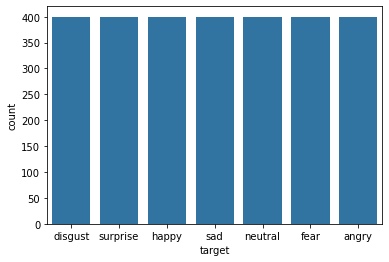

In [9]:
sns.countplot(x = "target", data = df, color = "tab:blue");

# Some Basic Visualizations

In this section, we will demonstrate an audio file (original and denoised versions) and its corresponding spectrogram. 

First, we show the graphical representation of an audio file by using library called `librosa` library. We will also denoise the loaded audio file by using python library `noisereduce`.

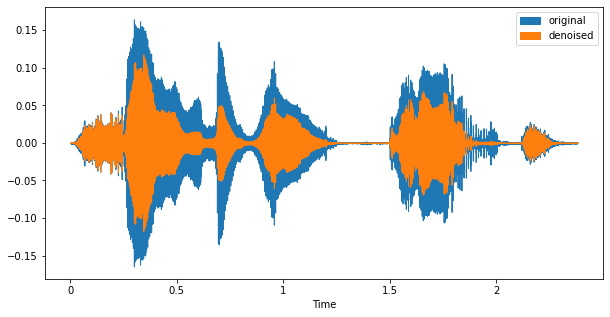

In [34]:
example_id = 0
audio_path = df["path"].iloc[example_id]
audio_target = df["target"].iloc[example_id]

x, sr = librosa.load(audio_path)
x_reduced = nr.reduce_noise(y=x, sr=sr)

plt.figure(figsize=(10, 5))
librosa.display.waveshow(x, sr=sr, label = "original")
librosa.display.waveshow(x_reduced, sr=sr, label = "denoised")
plt.legend();


Now, by using the the above-mentioned libraries, we will get the mel-spectrograms of the original and noise free audio loaded audio file

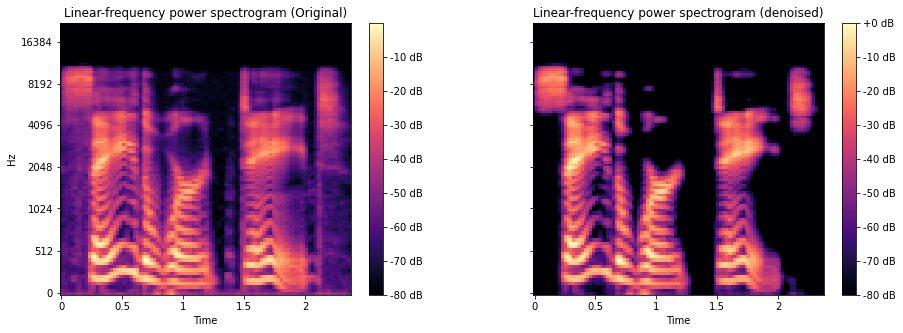

In [35]:
figs, axes = plt.subplots(ncols = 2, figsize = (15, 5))
figs.subplots_adjust(hspace=0.4, wspace=0.3)

hl = 512 # number of samples per time-step in spectrogram
hi = 100 # Height of image
wi = 384 # Width of image
fmax = sr

S = librosa.feature.melspectrogram(y=x, sr=sr, 
                                   n_mels=hi, fmax=fmax,
                                   n_fft=2048, hop_length=hl)

S_reduced = librosa.feature.melspectrogram(y=x_reduced, sr=sr, 
                                           n_mels=hi, fmax=fmax,
                                           n_fft=2048, hop_length=hl)

S_dB = librosa.power_to_db(S, ref=np.max)
S_reduced_dB = librosa.power_to_db(S_reduced, ref=np.max)



img_1 = librosa.display.specshow(S_dB, x_axis='time', 
                         y_axis='mel', sr=sr, 
                         fmax=fmax, ax = axes[0])
axes[0].set(title='Linear-frequency power spectrogram (Original)')
axes[0].label_outer()
figs.colorbar(img_1, ax=axes[0], format="%+2.f dB");

img_2 = librosa.display.specshow(S_reduced_dB, x_axis='time', 
                         y_axis='mel', sr=sr, 
                         fmax=fmax, ax = axes[1])
axes[1].set(title='Linear-frequency power spectrogram (denoised)')
axes[1].label_outer()
figs.colorbar(img_2, ax=axes[1], format="%+2.f dB");


# Effects of emotion in saying a word `door`

In this section, we will show different audio files and their spectrogram for different way of saying the word `door`, meaning that we want to see how saying a word affects the spectrogram of the audio file. 

In [36]:
door = df[["name", "target", "path"]].copy()
door["door"] = pd.DataFrame(door["name"].apply(lambda x: "YAF_door" in x).astype(float))

emotion_door = door.loc[door["door"] == 1.0][["target", "path"]]
emotion_door.reset_index(inplace = True, drop = True)

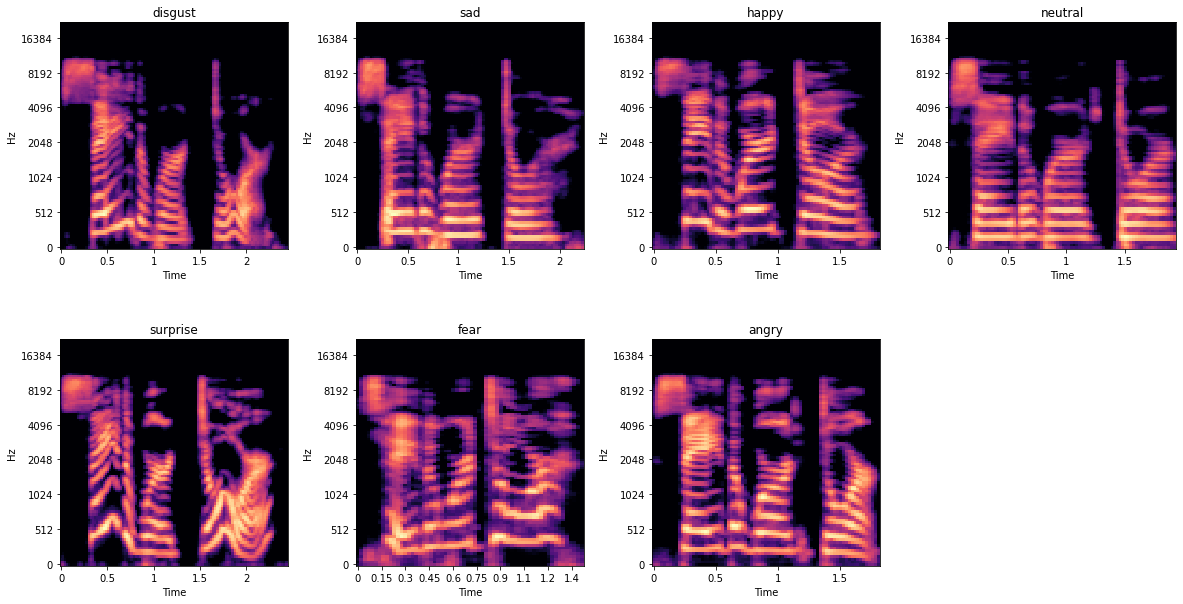

In [37]:
figs, axes = plt.subplots(nrows = 2 , ncols = 4, figsize = (20, 10))
figs.subplots_adjust(hspace=0.4, wspace=0.3)

for i in range(0, len(emotion_door)):
 
    ax = axes[i//4][i%4]
    audio_path = emotion_door.iloc[i]["path"]
    emotion = emotion_door.iloc[i]["target"]
    x, sr = librosa.load(audio_path)
    x_reduced = nr.reduce_noise(y=x, sr=sr)
    
    S_reduced = librosa.feature.melspectrogram(y=x_reduced,
                                               sr=sr, 
                                               n_mels=hi, 
                                               fmax=fmax,
                                               n_fft=2048,
                                               hop_length=hl)


    S_reduced_dB = librosa.power_to_db(S_reduced, ref=np.max)
    img_reduced = librosa.display.specshow(S_reduced_dB, 
                                           x_axis='time', 
                                           y_axis='mel', 
                                           sr=sr, 
                                           fmax=fmax,
                                           ax = ax)
    ax.set_title(emotion)  
    
figs.delaxes(axes[1][3])    

In the next, we will show the graphical representation of the loaded audio files in the original and noise free form.

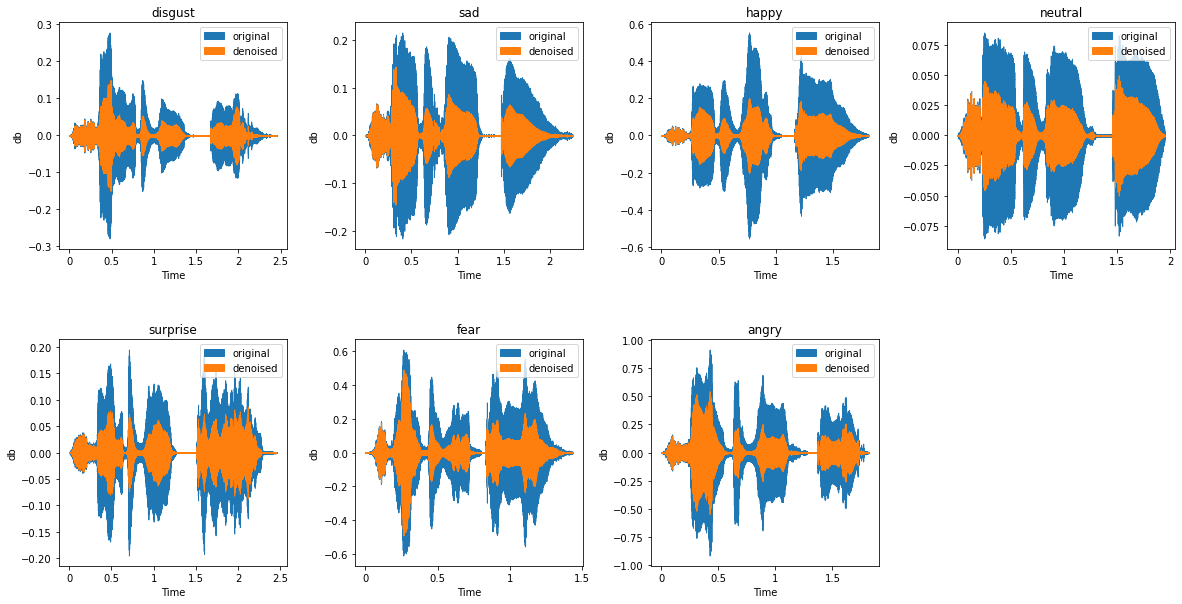

In [38]:
figs, axes = plt.subplots(nrows = 2 , ncols = 4, figsize = (20, 10))
figs.subplots_adjust(hspace=0.4, wspace=0.3)

for i in range(0, len(emotion_door)):  
    
    ax = axes[i//4][i%4]
    
    audio_path = emotion_door.iloc[i]["path"]
    emotion = emotion_door.iloc[i]["target"]
    x, sr = librosa.load(audio_path)
    x_reduced = nr.reduce_noise(y=x, sr=sr)
    librosa.display.waveshow(x, sr=sr, ax = ax, label = "original")
    librosa.display.waveshow(x_reduced, sr=sr, ax = ax, label = "denoised")
    ax.set_ylabel("db")
    ax.legend();
    ax.set_title(emotion)  
    
figs.delaxes(axes[1][3])      

# Length of audio files

In this section, we will plot the histogram of the length of audio files.

In [42]:
def time(data):
    x, sr = librosa.load(data)
    return len(x)/sr

df["time"] = df["path"].apply(lambda x: time(x))
print("DONE")

DONE


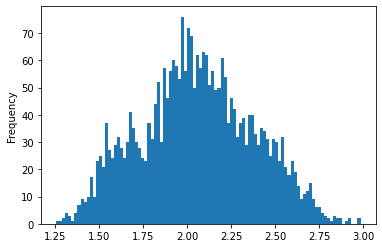

In [45]:
df["time"].plot(kind = "hist", bins = 100);

In [46]:
df = df.sample(frac = 1)
df.to_csv("df.csv")

# Train-Test-Split

In this section, we will split the data into train and test sets and we will save them for following notebooks.

In [232]:
y = df["target"]
X = df[["path", "name"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                   test_size = 0.2, 
                                                   random_state=42,
                                                   shuffle = True)

train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

train.to_csv("../Train-Test-Split/train.csv")
test.to_csv("../Train-Test-Split/test.csv")

# Mel Spectrogram

In this section, we will create and save the mel-spectrogram of the train and test sets and will save them for the following notebooks.


In [267]:
def mel_spectrogram(target, data, path, sr = 22050):
    
    hl = 512 
    hi = 100 
    wi = 384 
    fmax = sr
    
    phase5_path = "/Users/miladshirani/Documents/Flatiron/phase_5/Emotional Speech Recognition"
    mel_spectrogram = "mel_spectrogram"

    target_path = os.path.join(phase5_path,
                               mel_spectrogram, 
                               path, target)
    
    data_set = data[data["target"] == target]
    
    for i in tqdm(range(len(data_set))):
        
        audio_path = data_set["path"].iloc[i]
        audio_name = data_set["name"].iloc[i][:-4]
        
        x, _ = librosa.load(audio_path)
        x_reduced = nr.reduce_noise(y=x, sr=sr)
        
        S = librosa.feature.melspectrogram(y=x_reduced, sr=sr, n_mels=hi, 
                                           fmax=fmax, hop_length=hl)
        
        S_dB = librosa.power_to_db(S, ref=np.max)
        
        img = librosa.display.specshow(S_dB, 
                                       x_axis='mel', 
                                       y_axis='time', 
                                       sr=sr, 
                                       fmax=fmax)
        
        
        mel_name = audio_name + ".png"
        plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
        a = plt.gca()
        # set visibility of x-axis as False
        xax = a.axes.get_xaxis()
        xax = xax.set_visible(False)
  
        # set visibility of y-axis as False
        yax = a.axes.get_yaxis()
        yax = yax.set_visible(False)
        
        plt.ioff()
        plt.savefig(fname = os.path.join(target_path, mel_name),
                   dpi = 400,
                   bbox_inches = "tight",
                   pad_inches = 0)
        
        
        plt.close()
        
        
    print("DONE!") 

In [ ]:
targets = list(train["target"].unique())

In [269]:
for item in targets:
    print(f"{item}\n")
    mel_spectrogram(target = item, data = train, path = "train", sr = 22050)
    

  0%|          | 0/320 [00:00<?, ?it/s]

angry



  0%|          | 0/320 [00:00<?, ?it/s]

DONE!
surprise



  0%|          | 0/320 [00:00<?, ?it/s]

DONE!
neutral



  0%|          | 0/320 [00:00<?, ?it/s]

DONE!
fear



  0%|          | 0/320 [00:00<?, ?it/s]

DONE!
disgust



  0%|          | 0/320 [00:00<?, ?it/s]

DONE!
sad



  0%|          | 0/320 [00:00<?, ?it/s]

DONE!
happy



100%|██████████| 320/320 [01:52<00:00,  2.83it/s]

DONE!


In [270]:
for item in targets:
    print(f"{item}\n")
    mel_spectrogram(target = item, data = test, path = "test", sr = 22050)
    

  0%|          | 0/80 [00:00<?, ?it/s]

angry



  0%|          | 0/80 [00:00<?, ?it/s]

DONE!
surprise



  0%|          | 0/80 [00:00<?, ?it/s]

DONE!
neutral



  0%|          | 0/80 [00:00<?, ?it/s]

DONE!
fear



  0%|          | 0/80 [00:00<?, ?it/s]

DONE!
disgust



  0%|          | 0/80 [00:00<?, ?it/s]

DONE!
sad



  0%|          | 0/80 [00:00<?, ?it/s]

DONE!
happy



100%|██████████| 80/80 [00:29<00:00,  2.73it/s]

DONE!


In [272]:
targets = list(train["target"].unique())
targets

['angry', 'surprise', 'neutral', 'fear', 'disgust', 'sad', 'happy']

# Next

In the following notebooks, we will train several ML and NN models on the numerical values of the audio files and the spectrograms.